In [13]:
# Resolve paths from data_tools directory
import os
import sys

module_path = os.path.abspath(os.path.join("../data_tools"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
import pandas as pd
import numpy as np
raw_df = pd.read_csv("../saved/5m_journal_conf_comp_sci_with_rank_features.csv", index_col='PaperId.1')
raw_df.shape


(282456, 35)

In [9]:
# Drop PaperId because it doesn't correspond with the original paper id
raw_df.drop(["PaperId"], axis=1, inplace=True)

In [10]:
print("Num papers: ", raw_df.shape[0])
print("Include papers from the last 20 years")
df = raw_df[raw_df["YearsSincePublication"] <= 20]
print("Num papers: ", df.shape[0])
print("Drop papers without a Publisher")
df = df[df["Publisher"].isna() == False]
print("Num papers: ", df.shape[0])
print("Drop papers without a Journal")
df = df[df["JournalName"].isna() == False]
print("Num papers: ", df.shape[0])

Num papers:  282456
Include papers from the last 20 years
Num papers:  228905
Drop papers without a Publisher
Num papers:  217263
Drop papers without a Journal
Num papers:  69842


In [15]:
# Add processed abstract col
from nlp_tools import (
    preprocess_text_col
)
df = df.assign(Processed_Abstract=preprocess_text_col(df["Abstract"]))

## Feature Analysis


Higher rank -> more citations


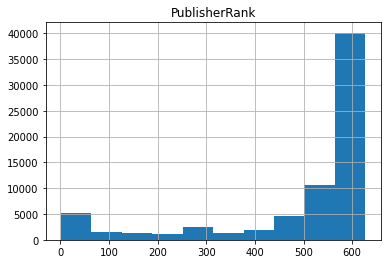

In [43]:
df.hist("PublisherRank")
print("Higher rank -> more citations")

Higher rank -> more citations


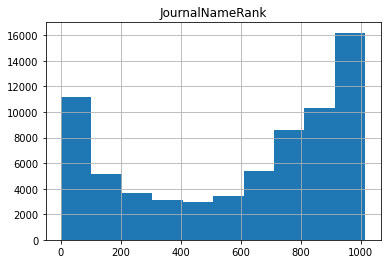

In [44]:
df.hist("JournalNameRank")
print("Higher rank -> more citations")

Higher rank -> more citations


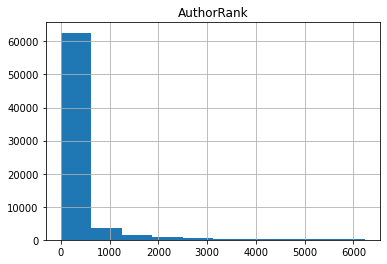

In [45]:
df.hist("AuthorRank")
print("Higher rank -> more citations")

In [46]:
df.to_csv("../saved/final_dataset_cs_papers_last_20.csv", index_label="PaperId")

In [47]:
loaded_df = pd.read_csv("../saved/final_dataset_cs_papers_last_20.csv", index_col='PaperId')
loaded_df.shape

(69842, 34)

In [48]:
loaded_df.head()

,Abstract,Author_1,Author_10,Author_11,Author_2,Author_3,Author_4,Author_5,Author_6,Author_7,...,Publisher,Rank,Title,YearsSincePublication,AuthorProminence,MagBin,CitationBin,AuthorRank,JournalNameRank,PublisherRank
PaperId,,,,,,,,,,,,,,,,,,,,,
2013266033,Two important automation characteristics are c...,1976502312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Academic Press, Inc.",22262,Crossing the boundaries of automation-Function...,5.668493,0,above-average,below-average,1.0,980.0,596.0
2147483772,The Japan Meteorological Agency (JMA) has deve...,2776874857,NaN,NaN,2.118487e+09,2.600472e+09,2.702858e+09,NaN,NaN,NaN,...,CODATA,20399,An Advanced System for Monitoring Geomagnetic ...,9.917808,0,low,below-average,1.0,449.0,358.0
2147483915,Many Internet of Things (IoT) technologies h...,2141485328,NaN,NaN,2.713835e+09,2.226086e+09,2.224880e+09,2.231733e+09,NaN,NaN,...,IEEE,18697,EasyConnect: A Management System for IoT Devic...,5.000000,1,low,high,1372.0,502.0,627.0
2147483970,This paper deals with an application of wavele...,2275778229,NaN,NaN,2.779769e+09,1.355326e+09,2.095098e+09,NaN,NaN,NaN,...,"Springer, Berlin, Heidelberg",20917,On the Performance of Informative Wavelets for...,18.961644,1,below-average,above-average,128.0,993.0,624.0
2013266260,An object-to-object color mapping method based...,2135137024,NaN,NaN,2.131763e+09,2.106423e+09,NaN,NaN,NaN,NaN,...,International Society for Optics and Photonics,22083,Object-to-object color mapping by image segmen...,19.923288,1,above-average,below-average,127.0,759.0,585.0
